# **Refining the model to predict the House Sale Price**

## Objectives

* The client is interested in predicting the house sale prices from her 4 inherited houses, and any other house in Ames, Iowa.
  * We need a way of checking the inherited houses vs the the selected variables and reliably pridict an outcome. 
  * We will likely use a conventional ML model to map the relationship between features and the target.
  * We will likely need hyperparameter optimization due to the conventional ML models used.

## Inputs

* outputs/datasets/cleaned/TestSetCleaned.csv
* outputs/datasets/cleaned/TrainSetCleaned.csv
* /workspace/PP5-ML/inputs/datasets/raw/house-price-20211124T154130Z-001/house-price/inherited_houses.csv

## Outputs

* /workspace/PP5-ML/outputs/datasets/collection

## Additional Comments

* In case you have any additional comments that don't fit in the previous bullets, please state them here. 


---

# Change working directory

* We are assuming you will store the notebooks in a subfolder, therefore when running the notebook in the editor, you will need to change the working directory

We need to change the working directory from its current folder to its parent folder
* We access the current directory with os.getcwd()

In [260]:
import os
current_dir = os.getcwd()
current_dir

'/workspace/PP5-ML'

We want to make the parent of the current directory the new current directory
* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory

In [261]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [262]:
current_dir = os.getcwd()
current_dir

'/workspace'

# Section 1 - Inport the data

cleaned data from section 3

In [263]:
import pandas as pd
df_cleaned = (pd.read_csv('/workspace/PP5-ML/outputs/datasets/cleaned/CleanedDataset.csv'))
df_cleaned.head(3)

,1stFlrSF,2ndFlrSF,BsmtFinSF1,GarageArea,GrLivArea,LotArea,OverallCond,OverallQual,TotalBsmtSF,YearBuilt,SalePrice,KitchenQual_encoded
0,856,854.0,706,548,1710,8450,5,7,856,2003,208500,3.0
1,1262,0.0,978,460,1262,9600,8,6,1262,1976,181500,2.0
2,920,866.0,486,608,1786,11250,5,7,920,2001,223500,3.0


## Make the pipeline

In [264]:
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, AdaBoostRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectFromModel
from feature_engine.selection import SmartCorrelatedSelection
import pandas as pd
import numpy as np

# Additional imports for evaluation and plotting
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')



In [265]:
# Define numerical and categorical features
num_features = ['OverallCond', 'GrLivArea', 'GarageArea', 'TotalBsmtSF', 'OverallQual', 'YearBuilt', '1stFlrSF', '2ndFlrSF', 'LotArea']
cat_features = ['KitchenQual_encoded']

# Preprocessor for the pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_features),
        ('cat', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), cat_features)
    ]
)


In [266]:
models_quick_search = { 
    'LinearRegression': LinearRegression(), 
    "DecisionTreeRegressor": DecisionTreeRegressor(random_state=0), 
    "RandomForestRegressor": RandomForestRegressor(random_state=0), 
    "ExtraTreesRegressor": ExtraTreesRegressor(random_state=0), 
    "AdaBoostRegressor": AdaBoostRegressor(random_state=0), 
    "GradientBoostingRegressor": GradientBoostingRegressor(random_state=0), 
    "XGBRegressor": XGBRegressor(random_state=0)
}

params_quick_search = {
    'LinearRegression': {},
    "DecisionTreeRegressor": {},
    "RandomForestRegressor": {},
    "ExtraTreesRegressor": {},
    "AdaBoostRegressor": {},
    "GradientBoostingRegressor": {},
    "XGBRegressor": {},
}
lasso_params = {'alpha': 2} 


In [267]:
# Define pipeline with Lasso and LinearRegression
def final_pipeline(lasso_params, model):
    the_pipeline_base = Pipeline([
        ('preprocessor', preprocessor),
        ('feature_selection', SelectFromModel(Lasso(**lasso_params, random_state=0))),
        ('model', model)
    ])
    return the_pipeline_base

# Create the pipeline with the specified parameters 
pipeline = final_pipeline(lasso_params, models_quick_search)
    
pipeline


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['OverallCond', 'GrLivArea',
                                                   'GarageArea', 'TotalBsmtSF',
                                                   'OverallQual', 'YearBuilt',
                                                   '1stFlrSF', '2ndFlrSF',
                                                   'LotArea']),
                                                 ('cat',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  ['KitchenQual_encoded'])])),
                ('feature_selection',
                 SelectFromModel(estimato...
                                               gpu_id=None, grow_policy=None,
                                               importance_type=None,
                                               interaction_constraints=None,
                                               learning_rate=None, max_bin=None,
                                               max_cat_threshold=None,
                                               max_cat_to_onehot=None,
                                               max_delta_step=None,
                                               max_depth=None, max_leaves=None,
                                               min_child_weight=None,
                                               missing=nan,
                                               monotone_constraints=None,
                                               n_estimators=100, n_jobs=None,
                                               num_parallel_tree=None,
                                               predictor=None, random_state=0, ...)})])

## HyperParameter Optimization

In [268]:
from sklearn.model_selection import GridSearchCV


class HyperparameterOptimizationSearch:

    def __init__(self, models, params, lasso_params):
        self.models = models
        self.params = params
        self.lasso_params = lasso_params
        self.keys = models.keys()
        self.grid_searches = {}

    def fit(self, X, y, cv, n_jobs, verbose=1, scoring=None, refit=False):
        for key in self.keys:
            print(f"\nRunning GridSearchCV for {key} \n")
            model = final_pipeline(self.lasso_params, self.models[key])

            params = self.params[key]
            gs = GridSearchCV(model, params, cv=cv, n_jobs=n_jobs,
                              verbose=verbose, scoring=scoring)
            gs.fit(X, y)
            self.grid_searches[key] = gs

    def score_summary(self, sort_by='mean_score'):
        def row(key, scores, params):
            d = {
                'estimator': key,
                'min_score': min(scores),
                'max_score': max(scores),
                'mean_score': np.mean(scores),
                'std_score': np.std(scores),
            }
            return pd.Series({**params, **d})

        rows = []
        for k in self.grid_searches:
            params = self.grid_searches[k].cv_results_['params']
            scores = []
            for i in range(self.grid_searches[k].cv):
                key = "split{}_test_score".format(i)
                r = self.grid_searches[k].cv_results_[key]
                scores.append(r.reshape(len(params), 1))

            all_scores = np.hstack(scores)
            for p, s in zip(params, all_scores):
                rows.append((row(k, s, p)))

        df = pd.concat(rows, axis=1).T.sort_values([sort_by], ascending=False)

        columns = ['estimator', 'min_score',
                   'mean_score', 'max_score', 'std_score']
        columns = columns + [c for c in df.columns if c not in columns]

        return df[columns], self.grid_searches


## Split The Data

In [269]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    df_cleaned.drop(['SalePrice'], axis=1),
    df_cleaned['SalePrice'],
    test_size=0.2,
    random_state=0
)

print("* Train set:", X_train.shape, y_train.shape,
      "\n* Test set:",  X_test.shape, y_test.shape)


* Train set: (1168, 11) (1168,) 
* Test set: (292, 11) (292,)


In [270]:
search = HyperparameterOptimizationSearch(models=models_quick_search, params=params_quick_search, lasso_params=lasso_params)
search.fit(X_train, y_train, scoring='r2', n_jobs=-1, cv=5)


Running GridSearchCV for LinearRegression 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for DecisionTreeRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for RandomForestRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for ExtraTreesRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for AdaBoostRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for GradientBoostingRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for XGBRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/workspace/.pip-modules/lib/python3.12/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/workspace/.pip-modules/lib/python3.12/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/workspace/.pip-modules/lib/python3.12/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/workspace/.pip-modules/lib/python3.12/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/workspace/.pip-modules/lib/python3.12/site-packages/xgboost/data.py:440: FutureWarning: is_

In [271]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary

,estimator,min_score,mean_score,max_score,std_score
2,RandomForestRegressor,0.749354,0.849258,0.890133,0.052513
3,ExtraTreesRegressor,0.707349,0.839122,0.891036,0.068184
5,GradientBoostingRegressor,0.702274,0.834621,0.893861,0.069449
0,LinearRegression,0.732465,0.818529,0.860964,0.044967
6,XGBRegressor,0.649834,0.794333,0.877638,0.095152
4,AdaBoostRegressor,0.685501,0.78464,0.829087,0.050893
1,DecisionTreeRegressor,0.590821,0.715626,0.785478,0.06787


In [272]:
models_search = {
    "RandomForestRegressor": RandomForestRegressor(random_state=0), 
}


params_search = {
    "RandomForestRegressor": { 
        'model__n_estimators': [100, 300], 
        'model__max_depth': [10, 20, None], 
        'model__min_samples_split': [2, 5], 
        'model__min_samples_leaf': [1, 2] 
    }, 
}


In [273]:
search = HyperparameterOptimizationSearch(models=models_search, params=params_search, lasso_params=lasso_params)
search.fit(X_train, y_train, scoring = 'r2', n_jobs=-1, cv=5)


Running GridSearchCV for RandomForestRegressor 

Fitting 5 folds for each of 24 candidates, totalling 120 fits


In [274]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary

,estimator,min_score,mean_score,max_score,std_score,model__max_depth,model__min_samples_leaf,model__min_samples_split,model__n_estimators
8,RandomForestRegressor,0.7584,0.852034,0.8895,0.04916,20,1,2,100
16,RandomForestRegressor,0.749354,0.849258,0.890133,0.052513,None,1,2,100
2,RandomForestRegressor,0.751765,0.847486,0.885789,0.050901,10,1,5,100
9,RandomForestRegressor,0.749708,0.846638,0.889497,0.052953,20,1,2,300
0,RandomForestRegressor,0.74445,0.846486,0.887692,0.054059,10,1,2,100
10,RandomForestRegressor,0.745514,0.846186,0.8875,0.053624,20,1,5,100
18,RandomForestRegressor,0.745979,0.846045,0.887403,0.053472,None,1,5,100
3,RandomForestRegressor,0.749234,0.845386,0.887014,0.052116,10,1,5,300
1,RandomForestRegressor,0.74616,0.84532,0.888641,0.053914,10,1,2,300
17,RandomForestRegressor,0.746327,0.844925,0.889798,0.054155,None,1,2,300


In [275]:
best_model = grid_search_summary.iloc[0, 0]
best_model

'RandomForestRegressor'

In [276]:
grid_search_pipelines[best_model].best_params_

{'model__max_depth': 20,
 'model__min_samples_leaf': 1,
 'model__min_samples_split': 2,
 'model__n_estimators': 100}

In [277]:
best_model = search.grid_searches['RandomForestRegressor'].best_estimator_

In [278]:
# Extract the pipeline components 
preprocessor = best_model.named_steps['preprocessor'] 
feature_selector = best_model.named_steps['feature_selection'] 
final_model = best_model.named_steps['model'] 

# Get the original feature names 
all_features = num_features + cat_features

In [279]:
selected_mask = feature_selector.get_support() 
selected_features = [feature for feature, selected in zip(all_features, selected_mask) if selected] 

print("Selected Features:", selected_features)

Selected Features: ['OverallCond', 'GrLivArea', 'GarageArea', 'TotalBsmtSF', 'OverallQual', 'YearBuilt', '1stFlrSF', '2ndFlrSF', 'LotArea', 'KitchenQual_encoded']


* These are the most important features in descending order. The model was trained on them: 
['OverallQual', 'GrLivArea', 'TotalBsmtSF', 'GarageArea', '1stFlrSF', 'YearBuilt', 'LotArea', '2ndFlrSF', 'KitchenQual_encoded', 'OverallCond']


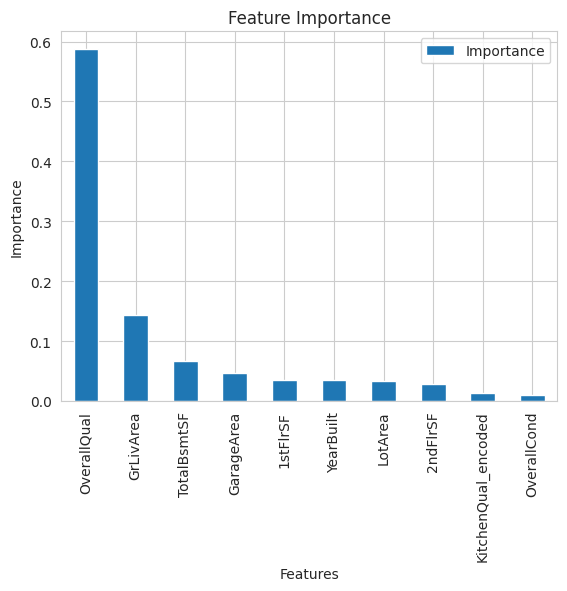

In [280]:
# Visualize Feature Importances (for tree-based models) 
if hasattr(final_model, 'feature_importances_'): 
    df_feature_importance = pd.DataFrame(data={ 
        'Feature': selected_features, 
        'Importance': final_model.feature_importances_ 
    }).sort_values(by='Importance', ascending=False) 

    print(f"* These are the most important features in descending order. The model was trained on them: \n{df_feature_importance['Feature'].to_list()}") 

    df_feature_importance.plot(kind='bar', x='Feature', y='Importance') 
    plt.title('Feature Importance') 
    plt.xlabel('Features') 
    plt.ylabel('Importance') 
    plt.show() 
else: 
    print("Selected Features:", selected_features)

## Look at that. Square one again.

In [281]:
df_cleaned

,1stFlrSF,2ndFlrSF,BsmtFinSF1,GarageArea,GrLivArea,LotArea,OverallCond,OverallQual,TotalBsmtSF,YearBuilt,SalePrice,KitchenQual_encoded
0,856,854.000000,706,548,1710,8450,5,7,856,2003,208500,3.0
1,1262,0.000000,978,460,1262,9600,8,6,1262,1976,181500,2.0
2,920,866.000000,486,608,1786,11250,5,7,920,2001,223500,3.0
3,961,348.524017,216,642,1717,9550,5,7,756,1915,140000,3.0
4,1145,348.524017,655,836,2198,14260,5,8,1145,2000,250000,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...
1455,953,694.000000,0,460,1647,7917,5,6,953,1999,175000,2.0
1456,2073,0.000000,790,500,2073,13175,6,6,1542,1978,210000,2.0
1457,1188,1152.000000,275,252,2340,9042,9,7,1152,1941,266500,3.0
1458,1078,0.000000,49,240,1078,9717,6,5,1078,1950,142125,3.0


---

In [282]:
df_cpy = df_cleaned.copy()
df_cpy.head()

,1stFlrSF,2ndFlrSF,BsmtFinSF1,GarageArea,GrLivArea,LotArea,OverallCond,OverallQual,TotalBsmtSF,YearBuilt,SalePrice,KitchenQual_encoded
0,856,854.000000,706,548,1710,8450,5,7,856,2003,208500,3.0
1,1262,0.000000,978,460,1262,9600,8,6,1262,1976,181500,2.0
2,920,866.000000,486,608,1786,11250,5,7,920,2001,223500,3.0
3,961,348.524017,216,642,1717,9550,5,7,756,1915,140000,3.0
4,1145,348.524017,655,836,2198,14260,5,8,1145,2000,250000,3.0


In [283]:
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.compose import ColumnTransformer

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_features),
    ]
)

In [284]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import AdaBoostRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor

def final_pipeline2(model):
    the_pipeline_base = Pipeline([
        ("SmartCorrelatedSelection", SmartCorrelatedSelection(variables=None,
         method="spearman", threshold=0.6, selection_method="variance")),

        ("feat_scaling", StandardScaler()),

        ("feat_selection",  SelectFromModel(model)),

        ("model", model),
    ])
    return the_pipeline_base


In [285]:
class HyperparameterOptimizationSearch:

    def __init__(self, models, params):
        self.models = models
        self.params = params
        self.keys = models.keys()
        self.grid_searches = {}

    def fit(self, X, y, cv, n_jobs, verbose=1, scoring=None, refit=False):
        for key in self.keys:
            print(f"\nRunning GridSearchCV for {key} \n")
            model = final_pipeline2(self.models[key])

            params = self.params[key]
            gs = GridSearchCV(model, params, cv=cv, n_jobs=n_jobs, verbose=verbose, scoring=scoring)
            gs.fit(X, y)
            self.grid_searches[key] = gs

    def score_summary(self, sort_by='mean_score'):
        def row(key, scores, params):
            d = {
                'estimator': key,
                'min_score': min(scores),
                'max_score': max(scores),
                'mean_score': np.mean(scores),
                'std_score': np.std(scores),
            }
            return pd.Series({**params, **d})

        rows = []
        for k in self.grid_searches:
            params = self.grid_searches[k].cv_results_['params']
            scores = []
            for i in range(self.grid_searches[k].cv):
                key = "split{}_test_score".format(i)
                r = self.grid_searches[k].cv_results_[key]
                scores.append(r.reshape(len(params), 1))

            all_scores = np.hstack(scores)
            for p, s in zip(params, all_scores):
                rows.append((row(k, s, p)))

        df = pd.concat(rows, axis=1).T.sort_values([sort_by], ascending=False)

        columns = ['estimator', 'min_score', 'mean_score', 'max_score', 'std_score']
        columns = columns + [c for c in df.columns if c not in columns]

        return df[columns], self.grid_searches


In [286]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    df_cpy.drop(['SalePrice'], axis=1),
    df_cpy['SalePrice'],
    test_size=0.2,
    random_state=0
)

print("* Train set:", X_train.shape, y_train.shape,
      "\n* Test set:",  X_test.shape, y_test.shape)


* Train set: (1168, 11) (1168,) 
* Test set: (292, 11) (292,)


In [287]:
models_quick_search = {
    "AdaBoostRegressor": AdaBoostRegressor(random_state=0),
    "GradientBoostingRegressor": GradientBoostingRegressor(random_state=0),
    "XGBRegressor": XGBRegressor(random_state=0)
}

params_quick_search = {
    "AdaBoostRegressor": {},
    "GradientBoostingRegressor": {},
    "XGBRegressor": {}
}

In [288]:
from sklearn.model_selection import GridSearchCV

def perform_grid_search(model, params, X_train, y_train):
    grid_search = GridSearchCV(estimator=model, param_grid=params, scoring='r2', n_jobs=-1, cv=5)
    grid_search.fit(X_train, y_train)
    return grid_search.best_estimator_, grid_search.best_score_

best_models = {}
best_scores = {}

for name, model in models_quick_search.items():
    print(f"Running GridSearchCV for {name}...")
    best_model, best_score = perform_grid_search(model, params_quick_search[name], X_train, y_train)
    best_models[name] = best_model
    best_scores[name] = best_score

for name, score in best_scores.items():
    print(f"{name}: Best R^2 Score = {score:.4f}")


Running GridSearchCV for AdaBoostRegressor...
Running GridSearchCV for GradientBoostingRegressor...
Running GridSearchCV for XGBRegressor...


/workspace/.pip-modules/lib/python3.12/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/workspace/.pip-modules/lib/python3.12/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/workspace/.pip-modules/lib/python3.12/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/workspace/.pip-modules/lib/python3.12/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or

AdaBoostRegressor: Best R^2 Score = 0.7901
GradientBoostingRegressor: Best R^2 Score = 0.8441
XGBRegressor: Best R^2 Score = 0.8370


In [289]:
models_search = {
    "GradientBoostingRegressor": GradientBoostingRegressor(random_state=0),
}

params_search = {
    "GradientBoostingRegressor": {
        'model__n_estimators': [100,300],
        'model__learning_rate': [1e-1,1e-2,1e-3], 
        'model__max_depth': [3,10,None],
    }
}

In [290]:
search = HyperparameterOptimizationSearch(models=models_search, params=params_search)
search.fit(X_train, y_train, scoring = 'r2', n_jobs=-1, cv=5)


Running GridSearchCV for GradientBoostingRegressor 

Fitting 5 folds for each of 18 candidates, totalling 90 fits


In [291]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary.head(5)

,estimator,min_score,mean_score,max_score,std_score,model__learning_rate,model__max_depth,model__n_estimators
7,GradientBoostingRegressor,0.645963,0.761608,0.835806,0.074043,0.01,3,300
0,GradientBoostingRegressor,0.597759,0.758625,0.833825,0.09311,0.1,3,100
1,GradientBoostingRegressor,0.549924,0.747491,0.831595,0.108873,0.1,3,300
9,GradientBoostingRegressor,0.52318,0.684282,0.821926,0.102891,0.01,10,300
2,GradientBoostingRegressor,0.488971,0.668617,0.817439,0.112185,0.1,10,100


In [292]:
best_model = grid_search_summary.iloc[0, 0]
best_model

'GradientBoostingRegressor'

In [293]:
grid_search_pipelines[best_model].best_params_

{'model__learning_rate': 0.01,
 'model__max_depth': 3,
 'model__n_estimators': 300}

In [294]:
best_regressor_pipeline = grid_search_pipelines[best_model].best_estimator_
best_regressor_pipeline

Pipeline(steps=[('SmartCorrelatedSelection',
                 SmartCorrelatedSelection(method='spearman',
                                          selection_method='variance',
                                          threshold=0.6)),
                ('feat_scaling', StandardScaler()),
                ('feat_selection',
                 SelectFromModel(estimator=GradientBoostingRegressor(random_state=0))),
                ('model',
                 GradientBoostingRegressor(learning_rate=0.01, n_estimators=300,
                                           random_state=0))])

* These are the 3 most important features in descending order. The model was trained on them: 
['GrLivArea', 'TotalBsmtSF', 'YearBuilt']


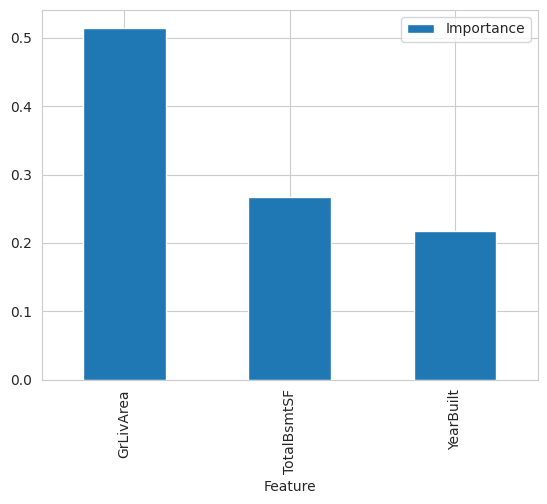

In [295]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

# after data cleaning and feature engineering, the features may have changes
# how many data cleaning and feature engineering steps does your pipeline have?
data_cleaning_feat_eng_steps = 1
columns_after_data_cleaning_feat_eng = (Pipeline(best_regressor_pipeline.steps[:data_cleaning_feat_eng_steps])
                                        .transform(X_train)
                                        .columns)

best_features = columns_after_data_cleaning_feat_eng[best_regressor_pipeline['feat_selection'].get_support(
)].to_list()

# create DataFrame to display feature importance
df_feature_importance = (pd.DataFrame(data={
    'Feature': columns_after_data_cleaning_feat_eng[best_regressor_pipeline['feat_selection'].get_support()],
    'Importance': best_regressor_pipeline['model'].feature_importances_})
    .sort_values(by='Importance', ascending=False)
)

# Most important features statement and plot
print(f"* These are the {len(best_features)} most important features in descending order. "
      f"The model was trained on them: \n{df_feature_importance['Feature'].to_list()}")

df_feature_importance.plot(kind='bar', x='Feature', y='Importance')
plt.show()


In [296]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import numpy as np


def regression_performance(X_train, y_train, X_test, y_test, pipeline):
    print("Model Evaluation \n")
    print("* Train Set")
    regression_evaluation(X_train, y_train, pipeline)
    print("* Test Set")
    regression_evaluation(X_test, y_test, pipeline)


def regression_evaluation(X, y, pipeline):
    prediction = pipeline.predict(X)
    print('R2 Score:', r2_score(y, prediction).round(3))
    print('Mean Absolute Error:', mean_absolute_error(y, prediction).round(3))
    print('Mean Squared Error:', mean_squared_error(y, prediction).round(3))
    print('Root Mean Squared Error:', np.sqrt(
        mean_squared_error(y, prediction)).round(3))
    print("\n")


def regression_evaluation_plots(X_train, y_train, X_test, y_test, pipeline, alpha_scatter=0.5):
    pred_train = pipeline.predict(X_train)
    pred_test = pipeline.predict(X_test)

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
    sns.scatterplot(x=y_train, y=pred_train, alpha=alpha_scatter, ax=axes[0])
    sns.lineplot(x=y_train, y=y_train, color='red', ax=axes[0])
    axes[0].set_xlabel("Actual")
    axes[0].set_ylabel("Predictions")
    axes[0].set_title("Train Set")

    sns.scatterplot(x=y_test, y=pred_test, alpha=alpha_scatter, ax=axes[1])
    sns.lineplot(x=y_test, y=y_test, color='red', ax=axes[1])
    axes[1].set_xlabel("Actual")
    axes[1].set_ylabel("Predictions")
    axes[1].set_title("Test Set")

    plt.show()


Model Evaluation 

* Train Set
R2 Score: 0.861
Mean Absolute Error: 20675.695
Mean Squared Error: 858503748.758
Root Mean Squared Error: 29300.235


* Test Set
R2 Score: 0.797
Mean Absolute Error: 23789.571
Mean Squared Error: 1405040820.182
Root Mean Squared Error: 37483.874




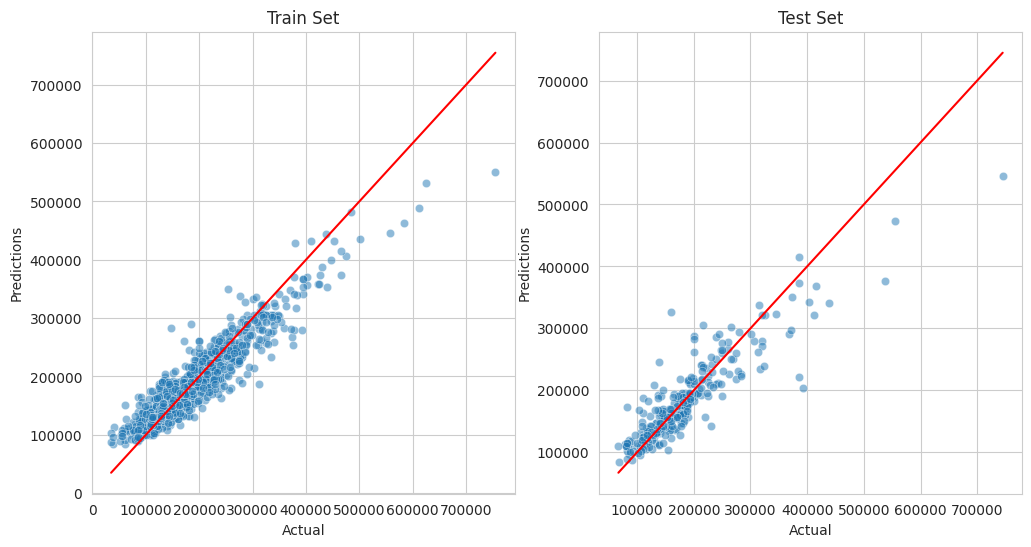

In [297]:
regression_performance(X_train, y_train, X_test, y_test, best_regressor_pipeline)
regression_evaluation_plots(X_train, y_train, X_test, y_test, best_regressor_pipeline)

In [382]:
best_regressor_pipeline

Pipeline(steps=[('SmartCorrelatedSelection',
                 SmartCorrelatedSelection(method='spearman',
                                          selection_method='variance',
                                          threshold=0.6)),
                ('feat_scaling', StandardScaler()),
                ('feat_selection',
                 SelectFromModel(estimator=GradientBoostingRegressor(random_state=0))),
                ('model',
                 GradientBoostingRegressor(learning_rate=0.01, n_estimators=300,
                                           random_state=0))])

## Lets save this as well

In [383]:
import joblib

version = 'v3'
file_path = f'outputs/ml_pipeline/predict_SalePrice/{version}'

try:
  os.makedirs(name=file_path)
except Exception as e:
  print(e)

In [384]:
joblib.dump(value=pipeline_clf, filename=f"{file_path}/best_regressor_pipeline.pkl")

['outputs/ml_pipeline/predict_SalePrice/v3/best_regressor_pipeline.pkl']

--------------

In [299]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA

# Define numerical and categorical features
num_features = ['1stFlrSF', '2ndFlrSF', 'BsmtFinSF1', 'GarageArea', 'GrLivArea', 'LotArea', 'TotalBsmtSF', 'YearBuilt', 'OverallCond', 'OverallQual']
cat_features = ['KitchenQual_encoded',]

# Update the preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_features),
        ('cat', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), cat_features)
    ]
)

# Create a pipeline with preprocessing and PCA steps
pipeline_pca = Pipeline([
    ('preprocessor', preprocessor),
    ('pca', PCA(n_components=5))
    
])

# Fit and transform the data using the pipeline without dropping 'YearBuilt'
df_pca = pipeline_pca.fit_transform(df_cpy)

print(df_pca.shape, '\n', type(df_pca))


(1460, 5) 
 <class 'numpy.ndarray'>


* The 5 components explain 100.0% of the data 



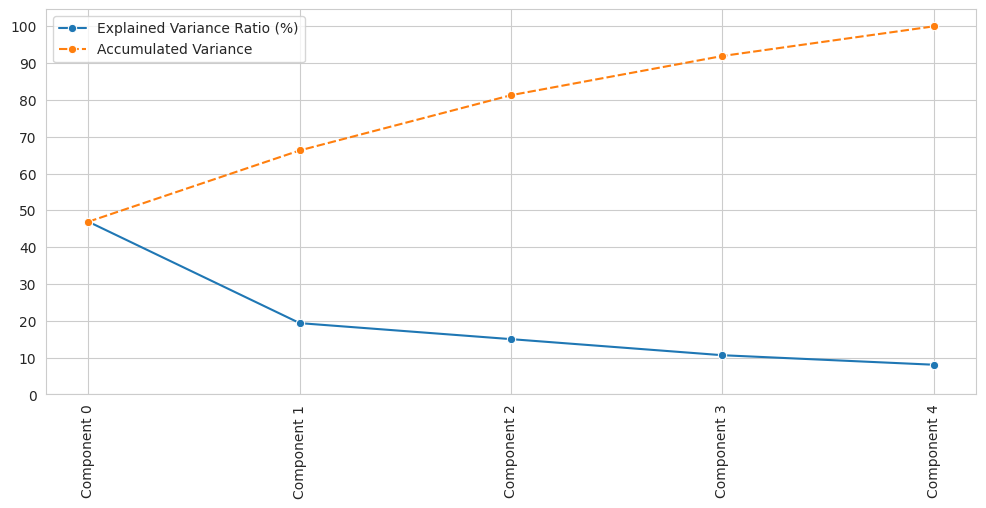

In [300]:
import numpy as np
from sklearn.decomposition import PCA

n_components = 5


def pca_components_analysis(df_pca, n_components):
    pca = PCA(n_components=n_components).fit(df_pca)
    x_PCA = pca.transform(df_pca)  # array with transformed PCA

    ComponentsList = ["Component " + str(number)
                      for number in range(n_components)]
    dfExplVarRatio = pd.DataFrame(
        data=np.round(100 * pca.explained_variance_ratio_, 3),
        index=ComponentsList,
        columns=['Explained Variance Ratio (%)'])

    dfExplVarRatio['Accumulated Variance'] = dfExplVarRatio['Explained Variance Ratio (%)'].cumsum(
    )

    PercentageOfDataExplained = dfExplVarRatio['Explained Variance Ratio (%)'].sum(
    )

    print(
        f"* The {n_components} components explain {round(PercentageOfDataExplained,2)}% of the data \n")
    plt.figure(figsize=(12, 5))
    sns.lineplot(data=dfExplVarRatio,  marker="o")
    plt.xticks(rotation=90)
    plt.yticks(np.arange(0, 110, 10))
    plt.show()


pca_components_analysis(df_pca=df_pca, n_components=n_components)


* The 3 components explain 81.29% of the data 



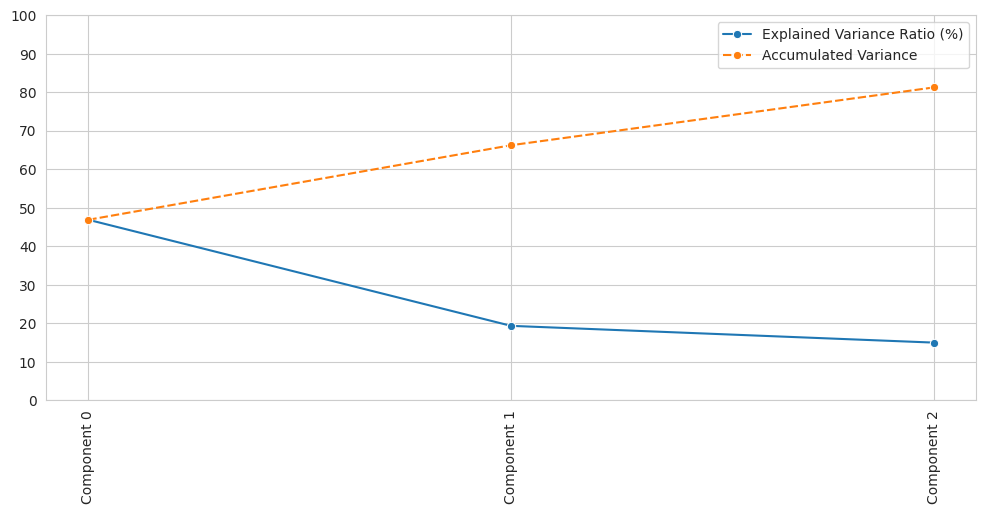

In [301]:
n_components = 3
pca_components_analysis(df_pca=df_pca, n_components=n_components)

In [302]:
# PCA
from sklearn.decomposition import PCA


def PipelineOptimization(model):
    pipeline_base = Pipeline([

        ("SmartCorrelatedSelection", SmartCorrelatedSelection(variables=None,
         method="spearman", threshold=0.6, selection_method="variance")),


        ("feat_scaling", StandardScaler()),

        # PCA replace Feature Selection
        ("PCA", PCA(n_components=3, random_state=0)),

        ("model", model),

    ])

    return pipeline_base


In [303]:
print("* Train set:", X_train.shape, y_train.shape, "\n* Test set:",  X_test.shape, y_test.shape)

* Train set: (1168, 11) (1168,) 
* Test set: (292, 11) (292,)


In [304]:
class HyperparameterOptimizationSearch:

    def __init__(self, models, params):
        self.models = models
        self.params = params
        self.keys = models.keys()
        self.grid_searches = {}

    def fit(self, X, y, cv, n_jobs, verbose=1, scoring=None, refit=False):
        for key in self.keys:
            print(f"\nRunning GridSearchCV for {key} \n")
            model = PipelineOptimization(self.models[key])

            params = self.params[key]
            gs = GridSearchCV(model, params, cv=cv, n_jobs=n_jobs, verbose=verbose, scoring=scoring)
            gs.fit(X, y)
            self.grid_searches[key] = gs

    def score_summary(self, sort_by='mean_score'):
        def row(key, scores, params):
            d = {
                'estimator': key,
                'min_score': min(scores),
                'max_score': max(scores),
                'mean_score': np.mean(scores),
                'std_score': np.std(scores),
            }
            return pd.Series({**params, **d})

        rows = []
        for k in self.grid_searches:
            params = self.grid_searches[k].cv_results_['params']
            scores = []
            for i in range(self.grid_searches[k].cv):
                key = "split{}_test_score".format(i)
                r = self.grid_searches[k].cv_results_[key]
                scores.append(r.reshape(len(params), 1))

            all_scores = np.hstack(scores)
            for p, s in zip(params, all_scores):
                rows.append((row(k, s, p)))

        df = pd.concat(rows, axis=1).T.sort_values([sort_by], ascending=False)

        columns = ['estimator', 'min_score', 'mean_score', 'max_score', 'std_score']
        columns = columns + [c for c in df.columns if c not in columns]

        return df[columns], self.grid_searches


## Use the standard hyperparameters

In [305]:
models_quick_search = {
    'LinearRegression': LinearRegression(),
    "DecisionTreeRegressor": DecisionTreeRegressor(random_state=0),
    "RandomForestRegressor": RandomForestRegressor(random_state=0),
    "ExtraTreesRegressor": ExtraTreesRegressor(random_state=0),
    "AdaBoostRegressor": AdaBoostRegressor(random_state=0),
    "GradientBoostingRegressor": GradientBoostingRegressor(random_state=0),
    "XGBRegressor": XGBRegressor(random_state=0),
}

params_quick_search = {
    'LinearRegression': {},
    "DecisionTreeRegressor": {},
    "RandomForestRegressor": {},
    "ExtraTreesRegressor": {},
    "AdaBoostRegressor": {},
    "GradientBoostingRegressor": {},
    "XGBRegressor": {},
}


In [306]:
quick_search = HyperparameterOptimizationSearch(models=models_quick_search, params=params_quick_search)
quick_search.fit(X_train, y_train, scoring='r2', n_jobs=-1, cv=5)


Running GridSearchCV for LinearRegression 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for DecisionTreeRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for RandomForestRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for ExtraTreesRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for AdaBoostRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for GradientBoostingRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for XGBRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/workspace/.pip-modules/lib/python3.12/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/workspace/.pip-modules/lib/python3.12/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/workspace/.pip-modules/lib/python3.12/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/workspace/.pip-modules/lib/python3.12/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/workspace/.pip-modules/lib/python3.12/site-packages/xgboost/data.py:440: FutureWarning: is_

Model Evaluation 

* Train Set
R2 Score: 0.861
Mean Absolute Error: 20675.695
Mean Squared Error: 858503748.758
Root Mean Squared Error: 29300.235


* Test Set
R2 Score: 0.797
Mean Absolute Error: 23789.571
Mean Squared Error: 1405040820.182
Root Mean Squared Error: 37483.874




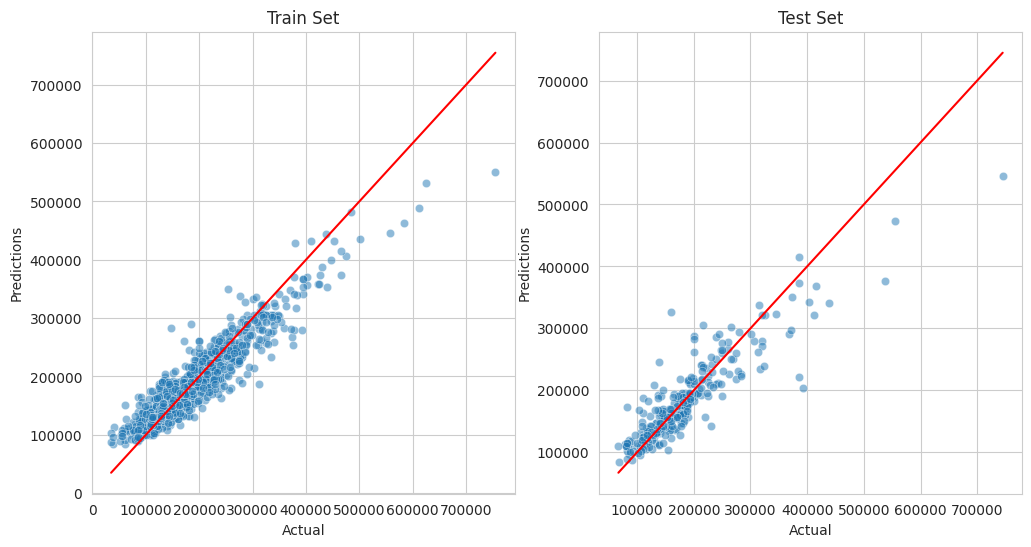

In [307]:
regression_performance(X_train, y_train, X_test, y_test,best_regressor_pipeline)
regression_evaluation_plots(X_train, y_train, X_test, y_test,
                            best_regressor_pipeline)

Convert Regression to Classification?

In [351]:
import pandas as pd
df_cleaned = (pd.read_csv('/workspace/PP5-ML/outputs/datasets/cleaned/CleanedDataset.csv'))
df_cleaned.head(3)

,1stFlrSF,2ndFlrSF,BsmtFinSF1,GarageArea,GrLivArea,LotArea,OverallCond,OverallQual,TotalBsmtSF,YearBuilt,SalePrice,KitchenQual_encoded
0,856,854.0,706,548,1710,8450,5,7,856,2003,208500,3.0
1,1262,0.0,978,460,1262,9600,8,6,1262,1976,181500,2.0
2,920,866.0,486,608,1786,11250,5,7,920,2001,223500,3.0


In [352]:
df_cpy = df_cleaned.copy()
df_cpy.head(3)

,1stFlrSF,2ndFlrSF,BsmtFinSF1,GarageArea,GrLivArea,LotArea,OverallCond,OverallQual,TotalBsmtSF,YearBuilt,SalePrice,KitchenQual_encoded
0,856,854.0,706,548,1710,8450,5,7,856,2003,208500,3.0
1,1262,0.0,978,460,1262,9600,8,6,1262,1976,181500,2.0
2,920,866.0,486,608,1786,11250,5,7,920,2001,223500,3.0


In [353]:
# Create the new column 'HealthCheck' as the sum of 'OverallCond' and 'OverallQual'
df_cpy['HealthCheck'] = df_cpy['OverallCond'] + df_cpy['OverallQual'] 

# Drop the original columns 'OverallCond' and 'OverallQual'
df_cpy.drop(columns=['OverallCond', 'OverallQual', '1stFlrSF', '2ndFlrSF', 'KitchenQual_encoded', 'BsmtFinSF1'], inplace=True)

# Verify the updated DataFrame
print(df_cpy.head())

   GarageArea  GrLivArea  LotArea  TotalBsmtSF  YearBuilt  SalePrice  \
0         548       1710     8450          856       2003     208500   
1         460       1262     9600         1262       1976     181500   
2         608       1786    11250          920       2001     223500   
3         642       1717     9550          756       1915     140000   
4         836       2198    14260         1145       2000     250000   

   HealthCheck   totalFlrSF  
0           12  1710.000000  
1           14  1262.000000  
2           12  1786.000000  
3           12  1309.524017  
4           13  1493.524017  


In [354]:
import seaborn as sns
import matplotlib.pyplot as plt
from feature_engine.discretisation import EqualFrequencyDiscretiser

disc = EqualFrequencyDiscretiser(q=5, variables=['GrLivArea', 'LotArea', 'HealthCheck', 'TotalBsmtSF', 'GarageArea', 'YearBuilt', 'SalePrice', 'totalFlrSF'])
df_clf = disc.fit_transform(df_cpy)

print(f"* The classes represent the following ranges: \n{disc.binner_dict_} \n")

print(df_clf.head())


* The classes represent the following ranges: 
{'GrLivArea': [-inf, 1066.6, 1339.0, 1578.0, 1869.0, inf], 'LotArea': [-inf, 7078.400000000001, 8793.4, 10198.2, 12205.8, inf], 'HealthCheck': [-inf, 10.0, 11.0, 12.0, 13.0, inf], 'TotalBsmtSF': [-inf, 755.8, 910.0, 1088.0, 1391.2, inf], 'GarageArea': [-inf, 295.6, 440.0, 516.0, 620.2, inf], 'YearBuilt': [-inf, 1947.8, 1965.0, 1984.0, 2003.0, inf], 'SalePrice': [-inf, 124000.0, 147000.0, 179280.00000000003, 230000.0, inf], 'totalFlrSF': [-inf, 1068.90480349345, 1340.0, 1573.0, 1867.2, inf]} 

   GarageArea  GrLivArea  LotArea  TotalBsmtSF  YearBuilt  SalePrice  \
0           3          3        1            1          3          3   
1           2          1        2            3          2          3   
2           3          3        3            2          3          3   
3           4          3        2            1          0          1   
4           4          4        4            3          3          4   

   HealthCheck  totalF

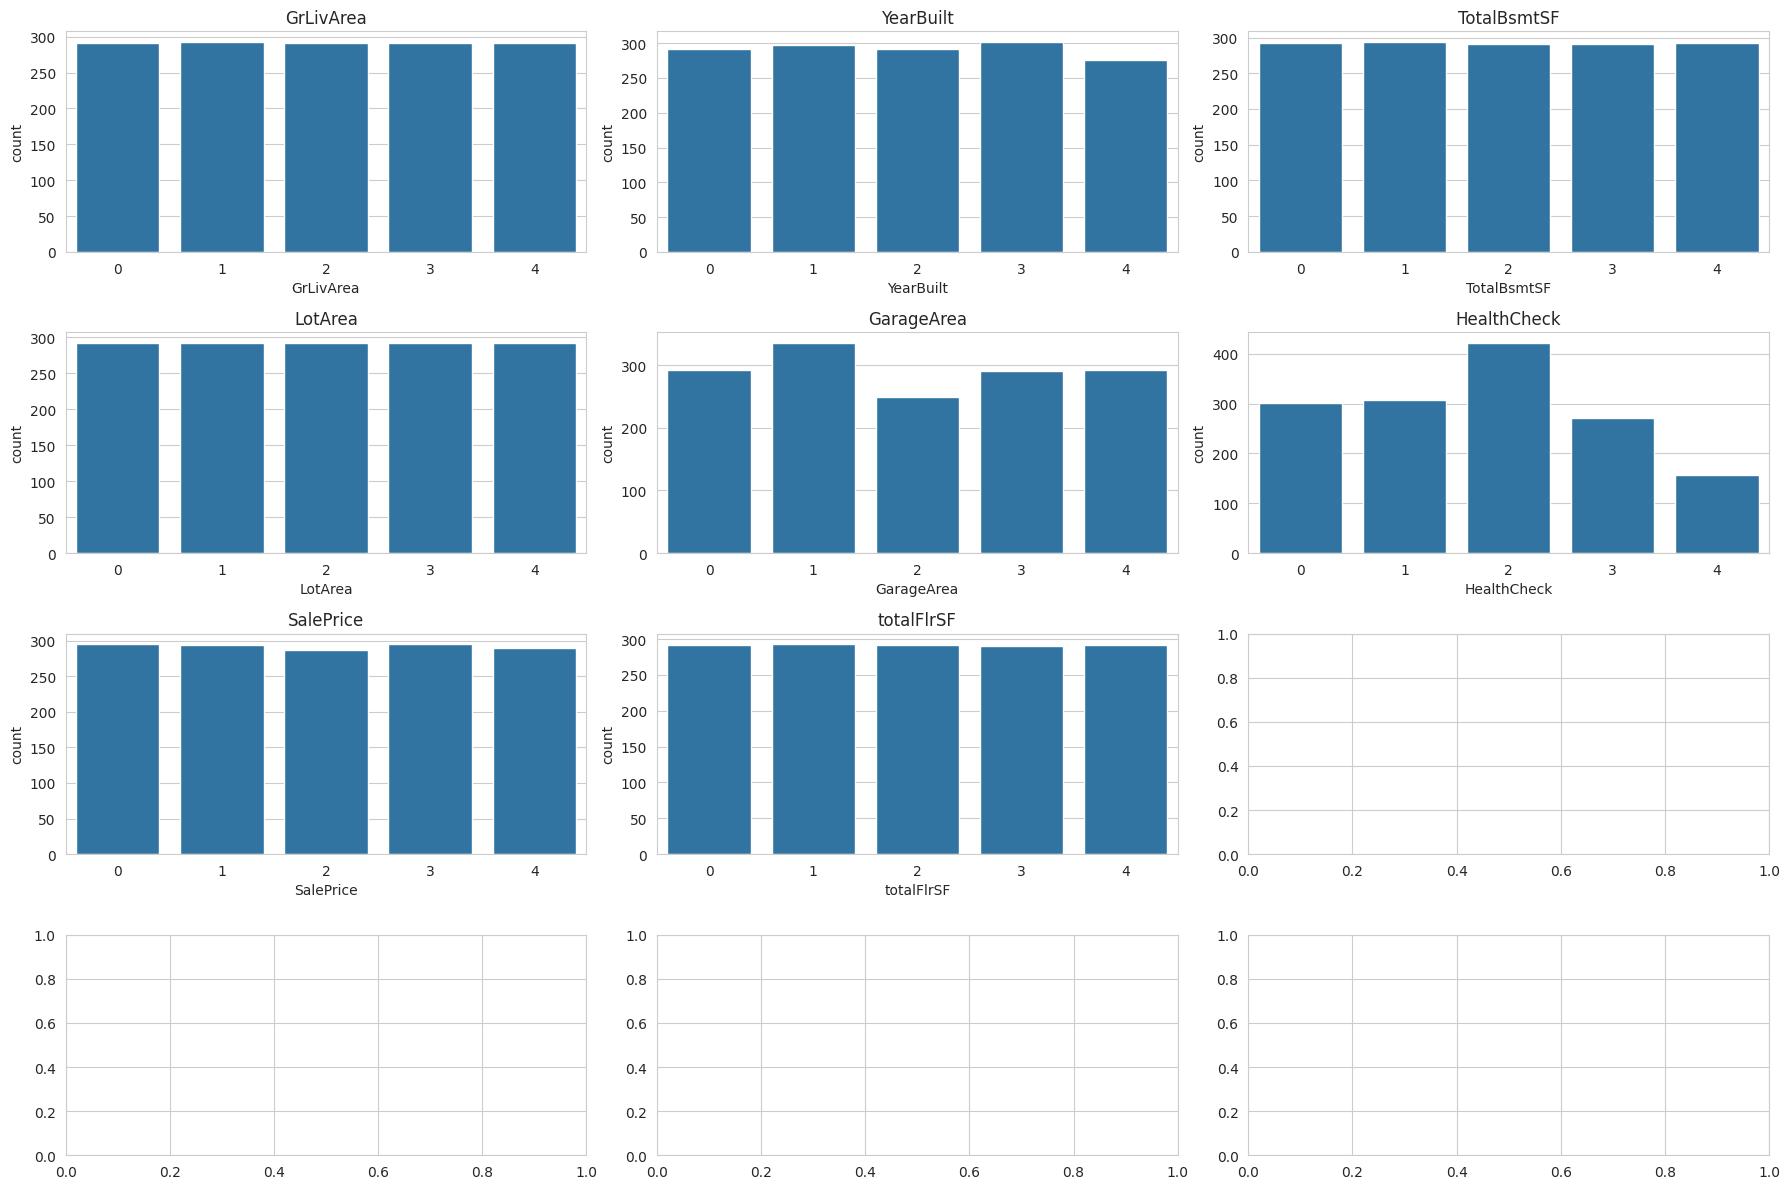

In [355]:
# Create subplots to show multiple graphs
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(18, 12))

# List of variables to plot
variables = ['GrLivArea', 'YearBuilt', 'TotalBsmtSF', 'LotArea', 'GarageArea', 'HealthCheck', 'SalePrice', 'totalFlrSF']

# Plot each variable in a subplot
for i, (variable) in enumerate(variables):
    row = i // 3
    col = i % 3
    sns.countplot(data=df_clf, x=variable, ax=axes[row, col])
    axes[row, col].set_title(variable)

# Adjust layout for better spacing
plt.tight_layout()
plt.show()


In [356]:
df_clf

,GarageArea,GrLivArea,LotArea,TotalBsmtSF,YearBuilt,SalePrice,HealthCheck,totalFlrSF
0,3,3,1,1,3,3,2,3
1,2,1,2,3,2,3,4,1
2,3,3,3,2,3,3,2,3
3,4,3,2,1,0,1,2,1
4,4,4,4,3,3,4,3,2
...,...,...,...,...,...,...,...,...
1455,2,3,1,2,3,2,1,3
1456,2,4,4,4,2,3,2,4
1457,0,4,2,3,0,4,4,4
1458,0,1,2,2,1,1,1,1


In [357]:
print(df_clf.columns)

Index(['GarageArea', 'GrLivArea', 'LotArea', 'TotalBsmtSF', 'YearBuilt',
       'SalePrice', 'HealthCheck', 'totalFlrSF'],
      dtype='object')


## Re-Write the pipeline again, again, again, again

In [358]:
def final_pipeline3(model):
    the_pipeline_base = Pipeline([
        ("SmartCorrelatedSelection", SmartCorrelatedSelection(variables=None,
         method="spearman", threshold=0.6, selection_method="variance")),

        ("feat_scaling", StandardScaler()),

        ("feat_selection",  SelectFromModel(model)),

        ("model", model),
    ])
    return the_pipeline_base


In [359]:
from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier 
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from feature_engine.selection import SmartCorrelatedSelection
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
import numpy as np
import pandas as pd

In [360]:
class HyperparameterOptimizationSearch:

    def __init__(self, models, params):
        self.models = models
        self.params = params
        self.keys = models.keys()
        self.grid_searches = {}

    def fit(self, X, y, cv, n_jobs, verbose=1, scoring=None, refit=False):
        for key in self.keys:
            print(f"\nRunning GridSearchCV for {key} \n")
            model = final_pipeline3(self.models[key])

            params = self.params[key]
            gs = GridSearchCV(model, params, cv=cv, n_jobs=n_jobs, verbose=verbose, scoring=scoring)
            gs.fit(X, y)
            self.grid_searches[key] = gs

    def score_summary(self, sort_by='mean_score'):
        def row(key, scores, params):
            d = {
                'estimator': key,
                'min_score': min(scores),
                'max_score': max(scores),
                'mean_score': np.mean(scores),
                'std_score': np.std(scores),
            }
            return pd.Series({**params, **d})

        rows = []
        for k in self.grid_searches:
            params = self.grid_searches[k].cv_results_['params']
            scores = []
            for i in range(self.grid_searches[k].cv):
                key = "split{}_test_score".format(i)
                r = self.grid_searches[k].cv_results_[key]
                scores.append(r.reshape(len(params), 1))

            all_scores = np.hstack(scores)
            for p, s in zip(params, all_scores):
                rows.append((row(k, s, p)))

        df = pd.concat(rows, axis=1).T.sort_values([sort_by], ascending=False)

        columns = ['estimator', 'min_score', 'mean_score', 'max_score', 'std_score']
        columns = columns + [c for c in df.columns if c not in columns]

        return df[columns], self.grid_searches

In [361]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    df_clf.drop(['SalePrice'], axis=1),
    df_clf['SalePrice'],
    test_size=0.2,
    random_state=0
)

print("* Train set:", X_train.shape, y_train.shape,
      "\n* Test set:",  X_test.shape, y_test.shape)


* Train set: (1168, 7) (1168,) 
* Test set: (292, 7) (292,)


In [362]:
models_quick_search = {
    "DecisionTreeClassifier": DecisionTreeClassifier(random_state=0),
    "RandomForestClassifier": RandomForestClassifier(random_state=0),
    "GradientBoostingClassifier": GradientBoostingClassifier(random_state=0),
    "ExtraTreesClassifier": ExtraTreesClassifier(random_state=0),
    "AdaBoostClassifier": AdaBoostClassifier(random_state=0),
}

params_quick_search = {
    "DecisionTreeClassifier":{},
    "RandomForestClassifier":{},
    "GradientBoostingClassifier":{},
    "ExtraTreesClassifier":{},
    "AdaBoostClassifier":{},
}

In [363]:
from sklearn.metrics import make_scorer, recall_score


quick_search = HyperparameterOptimizationSearch(models=models_quick_search, params=params_quick_search)
quick_search.fit(X_train, y_train,
                 scoring=make_scorer(recall_score, labels=[0], average=None),
                 n_jobs=-1, cv=3)

df_summary, grid_searches = quick_search.score_summary()
print(df_summary)


Running GridSearchCV for DecisionTreeClassifier 

Fitting 3 folds for each of 1 candidates, totalling 3 fits

Running GridSearchCV for RandomForestClassifier 

Fitting 3 folds for each of 1 candidates, totalling 3 fits



Running GridSearchCV for GradientBoostingClassifier 

Fitting 3 folds for each of 1 candidates, totalling 3 fits

Running GridSearchCV for ExtraTreesClassifier 

Fitting 3 folds for each of 1 candidates, totalling 3 fits

Running GridSearchCV for AdaBoostClassifier 

Fitting 3 folds for each of 1 candidates, totalling 3 fits
                    estimator min_score mean_score max_score std_score
4          AdaBoostClassifier  0.763158   0.834473  0.896104  0.054705
3        ExtraTreesClassifier  0.727273   0.756664  0.789474  0.025508
0      DecisionTreeClassifier  0.701299   0.734848  0.753247   0.02376
2  GradientBoostingClassifier  0.662338   0.699932  0.753247  0.038743
1      RandomForestClassifier  0.631579   0.678059  0.753247  0.053659


---

In [364]:
grid_search_summary, grid_search_pipelines = quick_search.score_summary(sort_by='mean_score')
grid_search_summary

,estimator,min_score,mean_score,max_score,std_score
4,AdaBoostClassifier,0.763158,0.834473,0.896104,0.054705
3,ExtraTreesClassifier,0.727273,0.756664,0.789474,0.025508
0,DecisionTreeClassifier,0.701299,0.734848,0.753247,0.02376
2,GradientBoostingClassifier,0.662338,0.699932,0.753247,0.038743
1,RandomForestClassifier,0.631579,0.678059,0.753247,0.053659


In [370]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

# Define your models
base_estimator = DecisionTreeClassifier(random_state=0)
models_search = {
    "AdaBoostClassifier": AdaBoostClassifier(base_estimator=base_estimator, random_state=0),
}

# Define your parameter grid
params_search = {
    "AdaBoostClassifier": {
        "model__n_estimators": [50, 100],  
        "model__learning_rate": [0.01, 0.1],  
        "model__algorithm": ["SAMME.R"], 
        "model__base_estimator__max_depth": [None, 5],  
        "model__base_estimator__min_samples_split": [2, 10],  
        "model__base_estimator__min_samples_leaf": [1, 2],  
        "model__base_estimator__max_features": ["sqrt"], 
        "model__base_estimator__min_impurity_decrease": [0.0], 
    }
}



In [371]:
from sklearn.metrics import make_scorer, recall_score

# Ensure HyperparameterOptimizationSearch is updated to use the keys correctly
search = HyperparameterOptimizationSearch(models=models_search, params=params_search)
search.fit(X_train, y_train,
           scoring=make_scorer(recall_score, labels=[0], average=None),
           n_jobs=-1, cv=3)



Running GridSearchCV for AdaBoostClassifier 

Fitting 3 folds for each of 32 candidates, totalling 96 fits


/workspace/.pip-modules/lib/python3.12/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/workspace/.pip-modules/lib/python3.12/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/workspace/.pip-modules/lib/python3.12/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/workspace/.pip-modules/lib/python3.12/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/workspace/.pip-modules/lib/python3.12/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  

In [372]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary.head(5)

,estimator,min_score,mean_score,max_score,std_score,model__algorithm,model__base_estimator__max_depth,model__base_estimator__max_features,model__base_estimator__min_impurity_decrease,model__base_estimator__min_samples_leaf,model__base_estimator__min_samples_split,model__learning_rate,model__n_estimators
0,AdaBoostClassifier,0.311688,0.478469,0.597403,0.12145,SAMME.R,None,sqrt,0.0,1,2,0.01,50
9,AdaBoostClassifier,0.311688,0.478469,0.597403,0.12145,SAMME.R,None,sqrt,0.0,2,2,0.01,100
1,AdaBoostClassifier,0.311688,0.478469,0.597403,0.12145,SAMME.R,None,sqrt,0.0,1,2,0.01,100
15,AdaBoostClassifier,0.311688,0.478469,0.597403,0.12145,SAMME.R,None,sqrt,0.0,2,10,0.1,100
14,AdaBoostClassifier,0.311688,0.478469,0.597403,0.12145,SAMME.R,None,sqrt,0.0,2,10,0.1,50


In [373]:
best_model = grid_search_summary.iloc[0,0]
best_model

'AdaBoostClassifier'

In [374]:
best_parameters = grid_search_pipelines[best_model].best_params_
best_parameters

{'model__algorithm': 'SAMME.R',
 'model__base_estimator__max_depth': None,
 'model__base_estimator__max_features': 'sqrt',
 'model__base_estimator__min_impurity_decrease': 0.0,
 'model__base_estimator__min_samples_leaf': 1,
 'model__base_estimator__min_samples_split': 2,
 'model__learning_rate': 0.01,
 'model__n_estimators': 50}

In [375]:
pipeline_clf = grid_search_pipelines[best_model].best_estimator_
pipeline_clf

Pipeline(steps=[('SmartCorrelatedSelection',
                 SmartCorrelatedSelection(method='spearman',
                                          selection_method='variance',
                                          threshold=0.6)),
                ('feat_scaling', StandardScaler()),
                ('feat_selection',
                 SelectFromModel(estimator=AdaBoostClassifier(base_estimator=DecisionTreeClassifier(random_state=0),
                                                              random_state=0))),
                ('model',
                 AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_features='sqrt',
                                                                          random_state=0),
                                    learning_rate=0.01, random_state=0))])

* These are the 1 most important features in descending order. The model was trained on them: 
['LotArea']


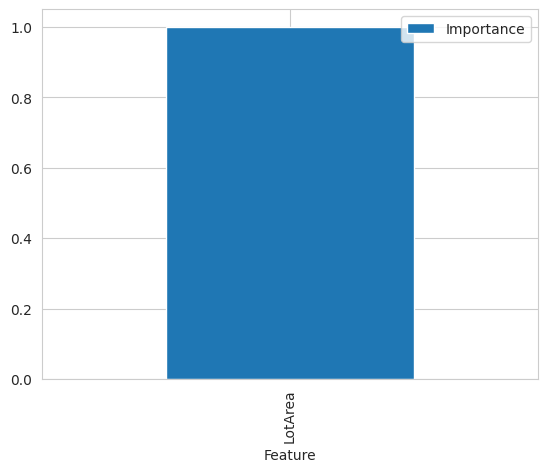

In [376]:
data_cleaning_feat_eng_steps = 1
columns_after_data_cleaning_feat_eng = (Pipeline(pipeline_clf.steps[:data_cleaning_feat_eng_steps])
                                        .transform(X_train)
                                        .columns)

best_features = columns_after_data_cleaning_feat_eng[pipeline_clf['feat_selection'].get_support(
)].to_list()

df_feature_importance = (pd.DataFrame(data={
    'Feature': columns_after_data_cleaning_feat_eng[pipeline_clf['feat_selection'].get_support()],
    'Importance': pipeline_clf['model'].feature_importances_})
    .sort_values(by='Importance', ascending=False)
)

best_features = df_feature_importance['Feature'].to_list()

print(f"* These are the {len(best_features)} most important features in descending order. "
      f"The model was trained on them: \n{best_features}")

df_feature_importance.plot(kind='bar', x='Feature', y='Importance')
plt.show()


In [377]:
from sklearn.metrics import classification_report, confusion_matrix


def confusion_matrix_and_report(X, y, pipeline, label_map):

    prediction = pipeline.predict(X)

    print('---  Confusion Matrix  ---')
    print(pd.DataFrame(confusion_matrix(y_true=prediction, y_pred=y),
          columns=[["Actual " + sub for sub in label_map]],
          index=[["Prediction " + sub for sub in label_map]]
          ))
    print("\n")

    print('---  Classification Report  ---')
    print(classification_report(y, prediction, target_names=label_map), "\n")


def clf_performance(X_train, y_train, X_test, y_test, pipeline, label_map):
    print("#### Train Set #### \n")
    confusion_matrix_and_report(X_train, y_train, pipeline, label_map)

    print("#### Test Set ####\n")
    confusion_matrix_and_report(X_test, y_test, pipeline, label_map)


In [378]:
label_map = ['Class 0', 'Class 1', 'Class 2', 'Class 3', 'Class 4']

In [379]:
clf_performance(X_train=X_train, y_train=y_train,
                        X_test=X_test, y_test=y_test,
                        pipeline=pipeline_clf,
                        label_map= label_map )

#### Train Set #### 

---  Confusion Matrix  ---
                   Actual Class 0 Actual Class 1 Actual Class 2  \
Prediction Class 0             93             57             44   
Prediction Class 1             56             66             49   
Prediction Class 2             45             51             52   
Prediction Class 3              0              0              0   
Prediction Class 4             36             65             89   

                   Actual Class 3 Actual Class 4  
Prediction Class 0             25             13  
Prediction Class 1             47              9  
Prediction Class 2             52             42  
Prediction Class 3              0              0  
Prediction Class 4            105            172  


---  Classification Report  ---
              precision    recall  f1-score   support

     Class 0       0.40      0.40      0.40       230
     Class 1       0.29      0.28      0.28       239
     Class 2       0.21      0.22      0.22  

/workspace/.pip-modules/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/workspace/.pip-modules/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/workspace/.pip-modules/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/workspace/.pip-modules/l

In [380]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import numpy as np


def regression_performance(X_train, y_train, X_test, y_test, pipeline):
    print("Model Evaluation \n")
    print("* Train Set")
    regression_evaluation(X_train, y_train, pipeline_clf)
    print("* Test Set")
    regression_evaluation(X_test, y_test, pipeline_clf)


def regression_evaluation(X, y, pipeline):
    prediction = pipeline_clf.predict(X)
    print('R2 Score:', r2_score(y, prediction).round(3))
    print('Mean Absolute Error:', mean_absolute_error(y, prediction).round(3))
    print('Mean Squared Error:', mean_squared_error(y, prediction).round(3))
    print('Root Mean Squared Error:', np.sqrt(
        mean_squared_error(y, prediction)).round(3))
    print("\n")


def regression_evaluation_plots(X_train, y_train, X_test, y_test, pipeline, alpha_scatter=0.5):
    pred_train = pipeline_clf.predict(X_train)
    pred_test = pipeline_clf.predict(X_test)

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
    sns.scatterplot(x=y_train, y=pred_train, alpha=alpha_scatter, ax=axes[0])
    sns.lineplot(x=y_train, y=y_train, color='red', ax=axes[0])
    axes[0].set_xlabel("Actual")
    axes[0].set_ylabel("Predictions")
    axes[0].set_title("Train Set")

    sns.scatterplot(x=y_test, y=pred_test, alpha=alpha_scatter, ax=axes[1])
    sns.lineplot(x=y_test, y=y_test, color='red', ax=axes[1])
    axes[1].set_xlabel("Actual")
    axes[1].set_ylabel("Predictions")
    axes[1].set_title("Test Set")

    plt.show()


Model Evaluation 

* Train Set
R2 Score: -0.335
Mean Absolute Error: 1.196
Mean Squared Error: 2.665
Root Mean Squared Error: 1.633


* Test Set
R2 Score: -0.374
Mean Absolute Error: 1.205
Mean Squared Error: 2.788
Root Mean Squared Error: 1.67




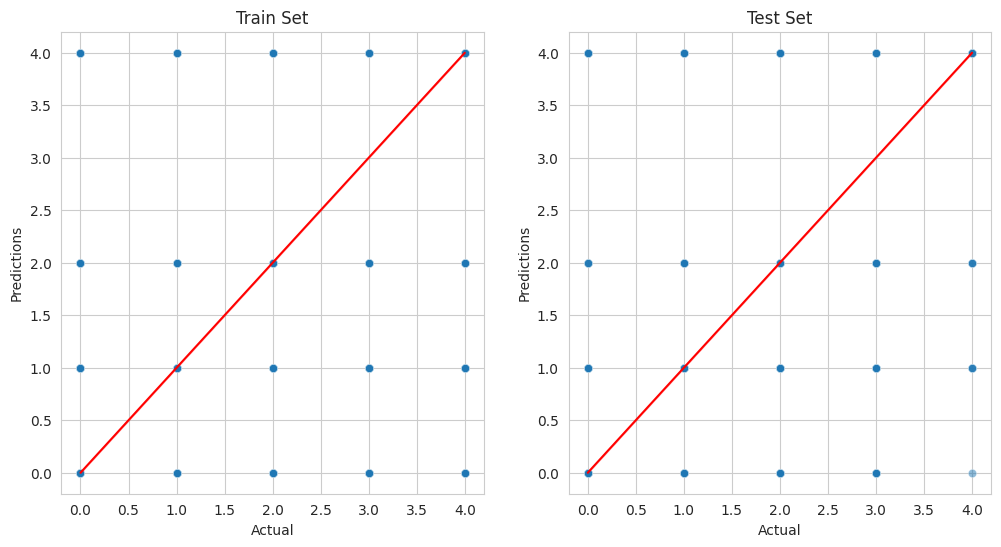

In [381]:
regression_performance(X_train, y_train, X_test, y_test, pipeline_clf)
regression_evaluation_plots(X_train, y_train, X_test, y_test, pipeline_clf)

----------

# We found a model that seems to perform well enough using a variety of factors in its evaulation. Time to save it up. 

In [334]:
pipeline_clf

Pipeline(steps=[('SmartCorrelatedSelection',
                 SmartCorrelatedSelection(method='spearman',
                                          selection_method='variance',
                                          threshold=0.6)),
                ('feat_scaling', StandardScaler()),
                ('feat_selection',
                 SelectFromModel(estimator=DecisionTreeClassifier(random_state=0))),
                ('model',
                 DecisionTreeClassifier(criterion='entropy',
                                        max_features='sqrt', min_samples_leaf=2,
                                        random_state=0))])

In [335]:
import joblib

version = 'v2'
file_path = f'outputs/ml_pipeline/predict_SalePrice/{version}'

try:
  os.makedirs(name=file_path)
except Exception as e:
  print(e)

In [336]:
X_train.head()

,GarageArea,GrLivArea,LotArea,TotalBsmtSF,YearBuilt,HealthCheck,totalFlrSF,PPSF
618,4,3,3,4,4,4,3,4
870,1,0,0,1,1,0,0,2
92,1,0,4,1,0,2,0,4
817,4,3,4,4,3,3,3,4
302,4,2,4,4,3,2,2,3


In [337]:
X_train.to_csv(f"{file_path}/X_train.csv", index=False)

In [338]:
y_train.head()

618    4
870    0
92     2
817    4
302    3
Name: SalePrice, dtype: int64

In [339]:
y_train.to_csv(f"{file_path}/y_train.csv", index=False)

In [340]:
X_test.head()

,GarageArea,GrLivArea,LotArea,TotalBsmtSF,YearBuilt,HealthCheck,totalFlrSF,PPSF
529,2,4,4,4,1,0,4,0
491,0,2,2,1,0,3,3,0
459,1,1,0,0,1,0,1,0
279,2,4,2,3,2,2,4,0
655,0,1,0,0,2,1,0,1


In [341]:
X_test.to_csv(f"{file_path}/X_test.csv", index=False)

In [342]:
y_test.head()

529    3
491    1
459    0
279    3
655    0
Name: SalePrice, dtype: int64

In [343]:
y_test.to_csv(f"{file_path}/y_test.csv", index=False)

In [344]:
pipeline_clf

Pipeline(steps=[('SmartCorrelatedSelection',
                 SmartCorrelatedSelection(method='spearman',
                                          selection_method='variance',
                                          threshold=0.6)),
                ('feat_scaling', StandardScaler()),
                ('feat_selection',
                 SelectFromModel(estimator=DecisionTreeClassifier(random_state=0))),
                ('model',
                 DecisionTreeClassifier(criterion='entropy',
                                        max_features='sqrt', min_samples_leaf=2,
                                        random_state=0))])

In [345]:
joblib.dump(value=pipeline_clf, filename=f"{file_path}/clf_pipeline.pkl")

['outputs/ml_pipeline/predict_SalePrice/v2/clf_pipeline.pkl']

In [346]:
label_map

['Class 0', 'Class 1', 'Class 2', 'Class 3', 'Class 4']

In [347]:
joblib.dump(value=label_map, filename=f"{file_path}/label_map.pkl")

['outputs/ml_pipeline/predict_SalePrice/v2/label_map.pkl']

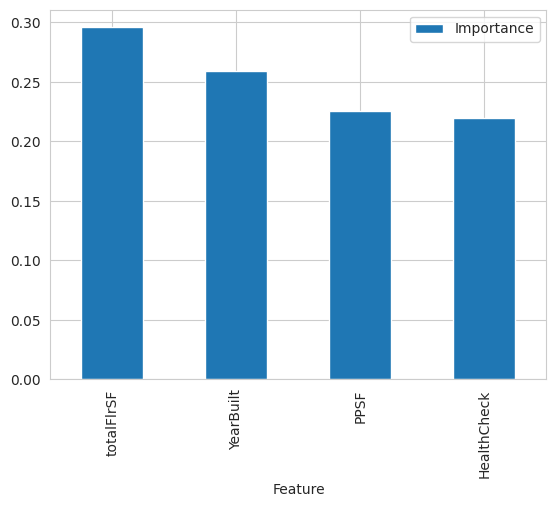

In [348]:
df_feature_importance.plot(kind='bar', x='Feature', y='Importance')
plt.show()

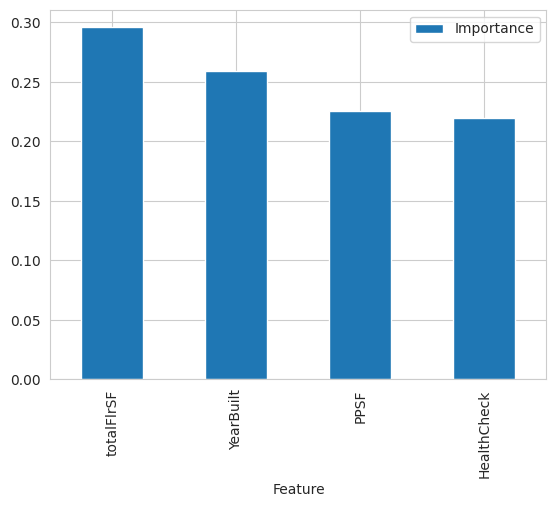

In [349]:
df_feature_importance.plot(kind='bar',x='Feature',y='Importance')
plt.savefig(f'{file_path}/features_importance.png', bbox_inches='tight')

---

NOTE

* You may add as many sections as you want, as long as they support your project workflow.
* All notebook's cells should be run top-down (you can't create a dynamic wherein a given point you need to go back to a previous cell to execute some task, like go back to a previous cell and refresh a variable content)

---